In [1]:
from typing import Optional, Iterable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from detector import SCVAEDetector

## Experiments with SKAB dataset

Let's split ```anomaly-free.csv``` dataset into two parts. Use the train part as a 'no anomaly' baseline meant for the network to learn what the processes look like in a stable system. 

Then we will take the testing part and try to see the network's opinion.

Even though the dataset is supposed to be anomaly free, when something not seen during training happens, we are still likely to detect some highly anomalous time windows.

In [2]:
def load_skab_no_anomalies():
    df = pd.read_csv(f'../datasets/skab/anomaly-free/anomaly-free.csv',sep=';').drop(columns=['datetime'])  
    id_cols = ['id_1']    
    return df, None

In [3]:
data,ids = load_skab_no_anomalies()

In [4]:
split_point = int(len(data)*0.75)
train_data = data.iloc[:split_point,:].copy()
test_data = data.iloc[split_point:,:].copy()

## MSE anomaly score

Anomaly score calculated using average MSE of 100 reconstructed samples against the real time-window. The higher the value, the more significant anomaly detected.

In [5]:
scvae = SCVAEDetector(latent_dim=16,time_window=8,batch_size=64,id_columns=ids)
scvae._init_empty_model(data)
scvae._model.load_weights("5000epochs_no_anomalies_train")

# might take a while :) we generate 100 samples in each shift of the rolling time window
train_res = scvae.predict_anomaly_scores(train_data[:400])
test_res = scvae.predict_anomaly_scores(test_data[:400])

### Train data

Low expected anomaly score overall, train data is supposed to be with no anomalies. The network should know how to reconstruct this data most of the time.

(-3.0, 3.0)

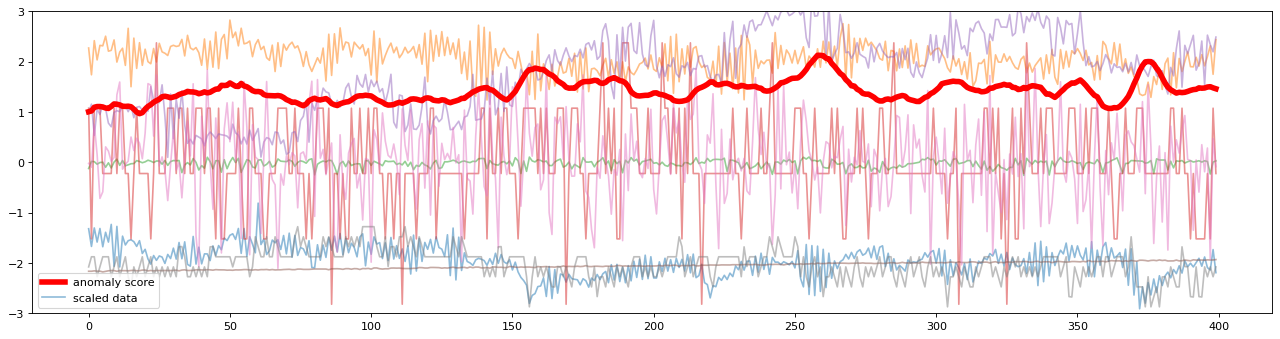

In [15]:
plt.figure(figsize=(20, 5), dpi=80)
plt.plot(scvae._scaler.transform(train_data[0:400]), alpha=0.5, label='scaled data')
plt.plot(np.array(train_res[0:400]), lw=5, c='red', label='anomaly score')
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels)
plt.ylim(-3,3)

## Test data

Higher average anomaly score expected than train data.

In case some of particular events ocurring that were not seen often in training data, we should see spikes in anomaly score.

(-3.0, 3.0)

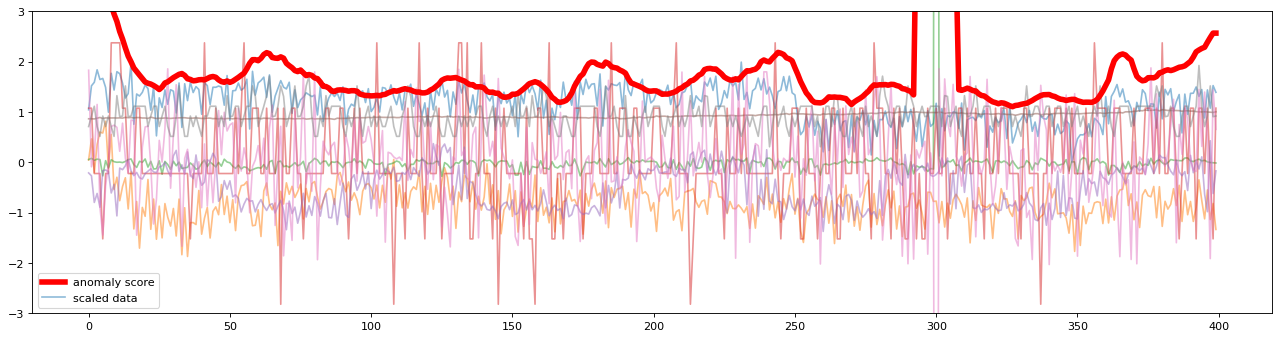

In [14]:
plt.figure(figsize=(20, 5), dpi=80)
plt.plot(scvae._scaler.transform(test_data[0:400]), alpha=0.5, label='scaled data')
plt.plot(np.array(test_res[0:400]), lw=5, c='red', label='anomaly score')
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels)
plt.ylim(-3,3)

As we can see, when the data spikes (purple + green), the anomaly score spikes as well (the score is elevated both before and after the anomaly, due to the width of the time window)

## Probability anomaly score

Please note the ```use_probability_reconstruction``` parameter in object creation.

In [108]:
scvae = SCVAEDetector(latent_dim=16,time_window=8,batch_size=64,id_columns=ids, use_probability_reconstruction=True)
scvae._init_empty_model(data)
scvae._scaler = StandardScaler()
scvae._scaler.fit(train_data)
scvae._model.load_weights("5000epochs_no_anomalies_train")
train_res = scvae.predict_anomaly_scores(train_data)
test_res = scvae.predict_anomaly_scores(test_data)

Reconstruction score implemented as described in the paper, but very unstable, reporting significant anomalies even in training data.

It's not a true probability anyway (it's a probability density), and there are some ambiguities even in the paper introducing the concept of using VAE to obtain reconstruction probability (see https://stats.stackexchange.com/questions/427597/obtaining-vae-reconstruction-probability)

SCVAE paper states that $\text{Anomaly score} = 1 - \text{Reconstruction probability}$, but using a probability density leads to values outside of 0-1 range.

In the plots below, time points with reconstruction score near zero are supposed to be highly anomalous. 

(-3.0, 3.0)

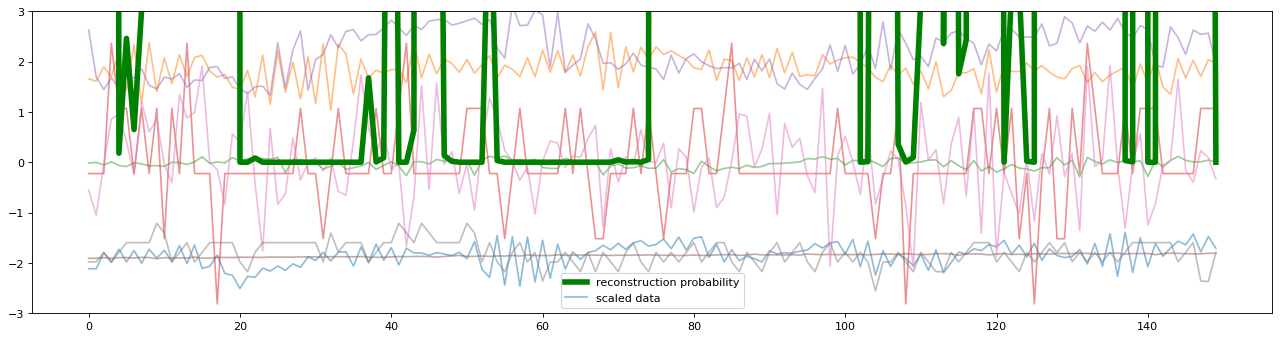

In [113]:
plt.figure(figsize=(20, 5), dpi=80)
plt.plot(scvae._scaler.transform(train_data[200:350]), alpha=0.5, label='scaled data')
plt.plot(np.array(train_res[200:350]), lw=5, c='green', label='reconstruction probability')
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels)
plt.ylim(-3,3)

As we can see, this way of discovering anomalies leads the network to recognize very little points as not anomalous even in the training set.

(-3.0, 3.0)

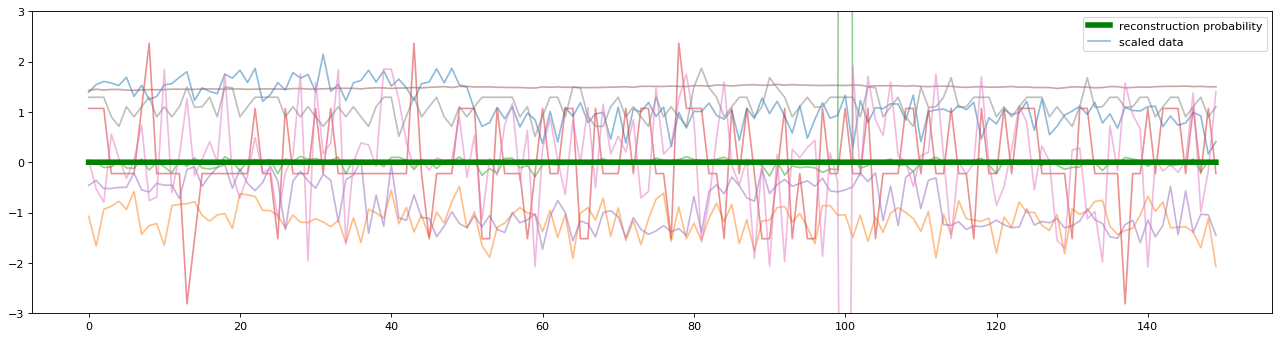

In [114]:
plt.figure(figsize=(20, 5), dpi=80)
plt.plot(scvae._scaler.transform(test_data[200:350]), alpha=0.5, label='scaled data')
plt.plot(np.array(test_res[200:350]), lw=5, c='green', label='reconstruction probability')
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels)
plt.ylim(-3,3)

Even worse, all points are apparently anomalous in the test set. 

With respect to the usage of MSE as reconstruction loss during training and these emprical observations from experimenting, the model is better suited with a MSE anomaly score.